# Case Study: Olympic medals

In this case study we explore the history of medals in the summer and winter olympics

The case study is divided into several parts:
- Goals
- Parsing
- Preparation (cleaning)
- Processing
- Exploration
- Visualization
- Conclusion

## Goals

In this section we define questions that will be our guideline througout the case study

- Which countries are over-/underperforming?
- Are some countries exceptional in some sports?
- Do physical traits have an influence on some sports?

We'll (try to) keep these question in mind when performing the case study.

## Parsing

we start out by importing all necessary libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
#set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = [10, 10]

in order to download datasets from kaggle, we need an API key to access their API, we'll make that here

In [2]:
if not os.path.exists(os.path.expanduser('~/.kaggle')):
    os.mkdir(os.path.expanduser('~/.kaggle'))

with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    json.dump(
        {
            "username":"lorenzf",
            "key":"7a44a9e99b27e796177d793a3d85b8cf"
        }
        , f)

now we can import kaggle too and download the datasets

In [3]:
import kaggle
kaggle.api.dataset_download_files(dataset='heesoo37/120-years-of-olympic-history-athletes-and-results', path='./data', unzip=True)

the csv files are now in the './data' folder, we can now read them using pandas, here is the list of all csv files in our folder

In [4]:
os.listdir('./data')

['WA_Fn-UseC_-Telco-Customer-Churn.csv',
 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_3358201.csv',
 'noc_regions.csv',
 'freeFormResponses.csv',
 'SurveySchema.csv',
 'jester_ratings.csv',
 'multipleChoiceResponses.csv',
 'one-million-reddit-jokes.csv',
 'jester_items.csv',
 'athlete_events.csv',
 'API_SP.POP.TOTL_DS2_en_csv_v2_3358390.csv']


The file of our interest is 'athlete_events.csv', it contains every contestant in every sport since 1896. Let's print out the top 5 events.

In [5]:
athlete_events = pd.read_csv('./data/athlete_events.csv')
print('shape: ' + str(athlete_events.shape))
athlete_events.head()

shape: (271116, 15)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


Seems we have a name, gender, age, height and weight of the contestant, as wel as the country they represent, the games they attended located in which city. The last 3 columns specify the sport, event within the sport and a possible medal. Presumably the keeping of their score would have been difficult as different sports use different score metrics which would be hard to compare.

In [6]:
noc_regions = pd.read_csv('./data/noc_regions.csv')
print('shape: ' + str(noc_regions.shape))
noc_regions.head()

shape: (230, 3)


,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


## Preparation

here we perform tasks to prepare the data in a more pleasing format.

### Data Types

Before we do anything with our data, it is good to see if our data types are in order

In [7]:
athlete_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [8]:
athlete_events[['Sex', 'Team', 'Season', 'City', 'Sport', 'Event']] = athlete_events[['Sex', 'Team', 'Season', 'City', 'Sport', 'Event']].astype('category')
athlete_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   ID      271116 non-null  int64   
 1   Name    271116 non-null  object  
 2   Sex     271116 non-null  category
 3   Age     261642 non-null  float64 
 4   Height  210945 non-null  float64 
 5   Weight  208241 non-null  float64 
 6   Team    271116 non-null  category
 7   NOC     271116 non-null  object  
 8   Games   271116 non-null  object  
 9   Year    271116 non-null  int64   
 10  Season  271116 non-null  category
 11  City    271116 non-null  category
 12  Sport   271116 non-null  category
 13  Event   271116 non-null  category
 14  Medal   39783 non-null   object  
dtypes: category(6), float64(3), int64(2), object(4)
memory usage: 20.8+ MB


### Missing values

for each dataframe we apply a few checks in order to see the quality of data

In [9]:
print(100*athlete_events.isna().sum()/athlete_events.shape[0])

ID         0.000000
Name       0.000000
Sex        0.000000
Age        3.494445
Height    22.193821
Weight    23.191180
Team       0.000000
NOC        0.000000
Games      0.000000
Year       0.000000
Season     0.000000
City       0.000000
Sport      0.000000
Event      0.000000
Medal     85.326207
dtype: float64


Age, 3.5% missing: 

Here we can't do much about it, we could impute using mean or median by looking at other contestants from the same sport/event, however I  have a feeling that missing ages might be prevalent in the same sports.


In [10]:
athlete_events.groupby('Year')['Age'].apply(lambda x: x.isna().sum()).sort_values(ascending=False).head(25)

Year
1948    1176
1924    1142
1928     963
1920     845
1900     790
1906     743
1908     649
1956     638
1932     330
1952     277
1904     274
1960     221
1984     216
1936     213
1980     187
1896     163
1912     156
1968     118
1988     110
1972      96
1964      56
1976      52
1992      44
1996       8
1994       2
Name: Age, dtype: int64

In [11]:
athlete_events.groupby('Sport')['Age'].apply(lambda x: x.isna().sum()).sort_values(ascending=False).head(25)

Sport
Gymnastics           1179
Athletics            1117
Shooting              821
Fencing               715
Cycling               678
Rowing                526
Swimming              524
Art Competitions      507
Wrestling             491
Football              375
Boxing                318
Sailing               285
Weightlifting         206
Hockey                204
Water Polo            200
Equestrianism         193
Basketball            186
Tennis                124
Diving                121
Archery                80
Alpine Skiing          78
Bobsleigh              72
Modern Pentathlon      53
Rugby                  48
Tug-Of-War             44
Name: Age, dtype: int64

Although some sports and years are more problematic, we cannot pinpoint a specific group where ages are missing. Imputing with mean or median would drasticly influence the distribution and standard deviation later on. I opt to leave the missing values as is and drop rows with NaN's when using age in calculations. 

Height & Weight, 22 & 23 % missing:

Similar to the Age, yet much more are missing, to a point where dropping would become problematic. Let's see if we can find a hotspot of missing data.

In [12]:
athlete_events.groupby('Year')[['Height', 'Weight']].apply(lambda x: x.isna().sum()).sort_values(by='Height', ascending=False).head(25)

,Height,Weight
Year,,
1952,7170,7171
1948,6311,6329
1936,6209,6414
1924,4719,5003
1928,4599,4856
1956,3748,3754
1920,3525,3821
1912,3319,3444
1992,3175,3157


In [13]:
athlete_events.groupby('Sport')[['Height', 'Weight']].apply(lambda x: x.isna().sum()).sort_values(by='Height', ascending=False).head(25)

,Height,Weight
Sport,,
Gymnastics,8045,8372
Athletics,5717,6023
Swimming,4045,4391
Shooting,3779,4148
Fencing,3773,4195
Art Competitions,3519,3523
Cycling,2883,3029
Rowing,2675,2662
Alpine Skiing,2435,2479


Again, no hotspots. For the same reason (distribution) we will not be imputing values, although for machine learning reasons this might be useful to increase the training pool. We will drop the rows with missing values whenever we use the height/weight columns. It would be wise here to inform our audience that conclusions on this data might be skewed by a possible bias - there might be a reason the data is missing - which might in turn cause us to make a wrongful conclusion!

Medal, 85% Missing:

Lastly we see that most are missing the medal, this is obviously that they did not win one. We could boldly assume that since each event has 3 medals, there must be an average of 20 contestants (17/20 = 85%). But this might be deviating over time and sport.

### Duplicates

For any reason, our dataset might be containing duplicates that would be counted twice and will introduce a bias we would not want. On the other hand, duplicates can be subjected to interpretation, here we would say that if 2 records share a name, gender, NOC, Games and event, the rows would be identical.
This would mean that the person would have performed twice in the same event for the same games under the same flag. The illustration below demonstrates a duplicate.

In [14]:
athlete_events[athlete_events.Name == 'Jacques Doucet']

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
57956,29661,Jacques Doucet,M,NaN,NaN,NaN,Favorite-17,FRA,1900 Summer,1900,Summer,Paris,Sailing,Sailing Mixed Open,NaN
57957,29661,Jacques Doucet,M,NaN,NaN,NaN,Favorite-1,FRA,1900 Summer,1900,Summer,Paris,Sailing,Sailing Mixed 2-3 Ton,Silver
57958,29661,Jacques Doucet,M,NaN,NaN,NaN,Favorite-1,FRA,1900 Summer,1900,Summer,Paris,Sailing,Sailing Mixed 2-3 Ton,Silver


We can se that Jacques for some reason is listed twice for the Sailing Mixed 2-3 Ton event. He won silver, but coming in second is no excused to be listed a second time! Perhaps we can find out where things went wrong by investigating in which year the duplicates appear.

In [15]:
duplicate_events = athlete_events[athlete_events.duplicated(['Name', 'Sex', 'NOC', 'Games', 'Event'])]
duplicate_events.groupby(['Year'])['Name'].count()

Year
1900    110
1908     35
1924    126
1928    347
1932    504
1936    258
1948    100
1968      2
1996      2
1998      3
2002      3
2012      1
Name: Name, dtype: int64

Seems most of them happen before 1948, perhaps due to errors in manual entries, it feels safe to delete them.

In [16]:
athlete_events = athlete_events.drop_duplicates(['Name', 'Sex', 'NOC', 'Games', 'Event'])

### Indexing

It is more convenient to work with an index, our dataset already contains an id which we can use as index

In [17]:
athlete_events = athlete_events.set_index('ID')
athlete_events.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


## Processing

### Medals per country per sport
To find out which country (NOC) performs the best, we would like to have a dataframe with 3 columns ['Gold', 'Silver', 'Bronze'] containing the count of each, as row index, we would have the games and the NOC, thus a multiindex.
An important detail is that team sports are given multiple medals, as indicated by the exampe below. Be careful as bias might not always as visible.

In [18]:
athlete_events[(athlete_events.Event == "Basketball Men's Basketball")&(athlete_events.Games=='1992 Summer')&(athlete_events.Medal=='Gold')]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
7901,Charles Wade Barkley,M,29.0,198.0,114.0,United States,USA,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Gold
11668,Larry Joe Bird,M,35.0,205.0,100.0,United States,USA,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Gold
30009,Clyde Austin Drexler,M,30.0,200.0,101.0,United States,USA,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Gold
33553,Patrick Aloysius Ewing,M,29.0,213.0,109.0,United States,USA,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Gold
55424,"Earvin ""Magic"" Johnson, Jr.",M,32.0,205.0,100.0,United States,USA,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Gold
55881,Michael Jeffrey Jordan,M,29.0,198.0,90.0,United States,USA,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Gold
65809,Christian Donald Laettner,M,22.0,211.0,107.0,United States,USA,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Gold
74176,Karl Malone,M,29.0,205.0,116.0,United States,USA,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Gold
83179,"Christopher Paul ""Chris"" Mullin",M,28.0,200.0,98.0,United States,USA,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Gold


The preprocessing for this dataframe seem complex but is combination of several operations:

- drop all records with no medals
- drop duplicates based on 'Games', 'NOC' , 'Event', 'Medal' to correct for team sports
- group per 'Games', 'NOC' , 'Medal'
- aggregate groups by calculating their size

At this point, we have a single column containing the amount of medals and 3 indices: 'Games' , 'NOC' and 'Medal'

- unstack the 'Medal' column to obtain 3 columns 'Gold', 'Silver', 'Bronze'
- make sure the order of columns is 'Gold', 'Silver', 'Bronze'
- drop rows where no medals are won, as we do not need those rows

This operation looks like the following:

In [19]:
medals_country_df = athlete_events.dropna(subset=['Medal']).drop_duplicates(['Games', 'NOC', 'Event']).groupby(['Games', 'NOC', 'Medal', 'Sport']).size().unstack('Medal')[['Gold', 'Silver', 'Bronze']]#.dropna(how='all')#.fillna(0)
medals_country_df = medals_country_df[medals_country_df.sum(axis='columns')>0]
medals_country_df

Medal                      Gold  Silver  Bronze
Games       NOC Sport                          
1896 Summer AUS Athletics     2       0       0
                Tennis        0       0       1
            AUT Cycling       1       0       2
                Swimming      1       1       0
            DEN Fencing       0       0       1
...                         ...     ...     ...
2016 Summer UZB Wrestling     0       0       3
            VEN Athletics     0       1       0
                Boxing        0       0       1
                Cycling       0       0       1
            VIE Shooting      1       1       0

[6915 rows x 3 columns]

### average statistics per year, country and sport

In [20]:
avg_stats_df = athlete_events.groupby(['Sex', 'NOC', 'Games', 'Sport'])[['Age', 'Height', 'Weight']].mean().dropna()
avg_stats_df

Age  Height  Weight
Sex NOC Games       Sport                          
F   AFG 2004 Summer Athletics  18.0   180.0    56.0
                    Judo       18.0   165.0    70.0
        2008 Summer Athletics  22.0   180.0    56.0
        2012 Summer Athletics  23.0   160.0    52.0
        2016 Summer Athletics  20.0   165.0    55.0
...                             ...     ...     ...
M   ZIM 2016 Summer Archery    37.0   186.0    78.0
                    Athletics  29.6   167.6    63.2
                    Rowing     27.0   191.0    87.0
                    Shooting   42.0   182.0    80.0
                    Swimming   22.0   181.0    84.0

[31329 rows x 3 columns]

## Exploration

At first we would like to know which countries are performing well, we could simply do a sum of all medals for each country as shown below

In [21]:
medals_agg_df = medals_country_df.groupby('NOC').sum().sort_values(by='Gold', ascending=False)
medals_agg_df.head(20)

Medal,Gold,Silver,Bronze
NOC,,,
USA,871,653,585
URS,405,298,285
GER,287,308,315
GBR,239,279,272
ITA,234,209,229
FRA,224,244,299
CHN,208,152,140
RUS,181,167,186
SWE,170,194,219


As expected, USA leads the charts, interestingly although disbanded over 30 years ago, the soviet are still second in amount of medals, this leads me to several questions:
- does every country have the same resources? 
- are some sports easier to obtain medals?
- is the type of medal important?

To create a simple answer on the last one, we could for each country calculate the percentage of gold/silver/bronze medals they obtained, meaning that not the amount but the ratio is important.

In [22]:
medals_perc_df = medals_agg_df[medals_agg_df.sum(axis='columns')>20].apply(lambda x: x/x.sum(), axis='columns').sort_values(by='Gold', ascending=False)
medals_perc_df.head(20)

Medal,Gold,Silver,Bronze
NOC,,,
ETH,0.476190,0.142857,0.380952
CHN,0.416000,0.304000,0.280000
USA,0.412992,0.309625,0.277383
URS,0.409919,0.301619,0.288462
TUR,0.402174,0.293478,0.304348
EUN,0.387931,0.310345,0.301724
NZL,0.387931,0.232759,0.379310
GDR,0.386417,0.299766,0.313817
NOR,0.371859,0.316583,0.311558


In [23]:
medals_agg_df.loc['ETH']

Medal
Gold      20
Silver     6
Bronze    16
Name: ETH, dtype: int64

Out of nowhere Ethiopia seems to be the highest achiever when it comes to gold medals, but this might be an anomaly as their total medal count is rather low, but still impressive! Also China steps up showing that they don't take second best.

I also mentioned resources, some countries are not as big as USA an China and therefore send less athletes.
We could have checked for the amount of athlete's yet opted to go for each countries population.
If a country has a bigger population it means it has a bigger pool of genetically favored persons for a sport.

To investigate this I searched for a dataset containing the data, coming from the worldbank API, in the next section we download the data.

In [24]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

In [25]:
resp = urlopen("https://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv")
zipfile = ZipFile(BytesIO(resp.read()))
print(f"found files: {zipfile.namelist()}")

found files: ['Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_3358390.csv', 'API_SP.POP.TOTL_DS2_en_csv_v2_3358390.csv', 'Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_3358390.csv']


In [26]:
file_name = 'API_SP.POP.TOTL_DS2_en_csv_v2_3358390.csv'
zipfile.extract(file_name, './data')
pop_df = pd.read_csv('./data/'+file_name, encoding='', skiprows=4)
pop_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,...,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0,NaN


You can see that for each year from 1960 the population for each country is given, we first have to stack/unpivot the data to obtain a view that is useful for our purpose.

In [27]:
pop_df = pop_df.drop(columns=['Country Name', 'Indicator Name', 'Indicator Code'] + pop_df.columns[pop_df.columns.str.contains('Unnamed')].tolist()).set_index('Country Code').stack()
pop_df = pop_df.rename('population')
pop_df.head(5)

Country Code      
ABW           1960    54208.0
              1961    55434.0
              1962    56234.0
              1963    56699.0
              1964    57029.0
Name: population, dtype: float64

Now we have to match this with our medals dataset we created earlier

In [28]:
medals_country_df.head()

Medal                      Gold  Silver  Bronze
Games       NOC Sport                          
1896 Summer AUS Athletics     2       0       0
                Tennis        0       0       1
            AUT Cycling       1       0       2
                Swimming      1       1       0
            DEN Fencing       0       0       1

There seems to be a problem, our medals dataset does not indicate the year, we can solve this by adding a column

In [29]:
medals_country_df['year'] = medals_country_df.index.get_level_values('Games').str[:4]
medals_country_df.head()

Medal                      Gold  Silver  Bronze  year
Games       NOC Sport                                
1896 Summer AUS Athletics     2       0       0  1896
                Tennis        0       0       1  1896
            AUT Cycling       1       0       2  1896
                Swimming      1       1       0  1896
            DEN Fencing       0       0       1  1896

Great! now we can merge the population data with our medals data

In [30]:
medals_country_pop_df = pd.merge(medals_country_df, pop_df, left_on=[medals_country_df.index.get_level_values('NOC'), 'year'], right_index=True, how='left')
medals_country_pop_df

Gold  Silver  Bronze  year  population
Games       NOC Sport                                            
1896 Summer AUS Athletics     2       0       0  1896         NaN
                Tennis        0       0       1  1896         NaN
            AUT Cycling       1       0       2  1896         NaN
                Swimming      1       1       0  1896         NaN
            DEN Fencing       0       0       1  1896         NaN
...                         ...     ...     ...   ...         ...
2016 Summer UZB Wrestling     0       0       3  2016  31847900.0
            VEN Athletics     0       1       0  2016  29851249.0
                Boxing        0       0       1  2016  29851249.0
                Cycling       0       0       1  2016  29851249.0
            VIE Shooting      1       1       0  2016         NaN

[6915 rows x 5 columns]

As our population data only contained data from 1960 onwards, we need to discard some of our rows, we do this with the dropna method

In [31]:
medals_country_pop_df = medals_country_pop_df.dropna()
medals_country_pop_df

Gold  Silver  Bronze  year  population
Games       NOC Sport                                                
1960 Summer ARG Boxing            0       0       1  1960  20481781.0
                Sailing           0       1       0  1960  20481781.0
            AUS Athletics         1       2       1  1960  10276477.0
                Boxing            0       0       2  1960  10276477.0
                Equestrianism     1       1       0  1960  10276477.0
...                             ...     ...     ...   ...         ...
2016 Summer UZB Weightlifting     1       0       0  2016  31847900.0
                Wrestling         0       0       3  2016  31847900.0
            VEN Athletics         0       1       0  2016  29851249.0
                Boxing            0       0       1  2016  29851249.0
                Cycling           0       0       1  2016  29851249.0

[3710 rows x 5 columns]

In order to use our population information, we need to be creative, I decided to keep things simple and for each type of medal divide the amount with the population, therefore the value is changed from:

- the amount of medals earned for a country

to

- the amount of medals earned per person for a country

Which will be much lower for countries with a higher population

In [32]:
medals_pop_df = medals_country_pop_df[['Gold', 'Silver', 'Bronze']].div(medals_country_pop_df.population,axis='index')
medals_pop_df

Gold        Silver        Bronze
Games       NOC Sport                                                  
1960 Summer ARG Boxing         0.000000e+00  0.000000e+00  4.882388e-08
                Sailing        0.000000e+00  4.882388e-08  0.000000e+00
            AUS Athletics      9.730961e-08  1.946192e-07  9.730961e-08
                Boxing         0.000000e+00  0.000000e+00  1.946192e-07
                Equestrianism  9.730961e-08  9.730961e-08  0.000000e+00
...                                     ...           ...           ...
2016 Summer UZB Weightlifting  3.139924e-08  0.000000e+00  0.000000e+00
                Wrestling      0.000000e+00  0.000000e+00  9.419773e-08
            VEN Athletics      0.000000e+00  3.349944e-08  0.000000e+00
                Boxing         0.000000e+00  0.000000e+00  3.349944e-08
                Cycling        0.000000e+00  0.000000e+00  3.349944e-08

[3710 rows x 3 columns]

You can see that these values are much lower as populations are very high. Now we can do exactly the same as before and sort per highest total amount.

In [33]:
medals_pop_df.groupby('NOC').sum().sort_values(by='Gold', ascending=False).head(20)

,Gold,Silver,Bronze
NOC,,,
LIE,0.000077,0.000077,0.000193
NOR,0.000022,0.000020,0.000018
NZL,0.000011,0.000007,0.000011
FIN,0.000010,0.000012,0.000014
HUN,0.000010,0.000010,0.000010
SWE,0.000008,0.000010,0.000010
CUB,0.000007,0.000006,0.000006
CHI,0.000007,0.000014,0.000013
AUS,0.000007,0.000008,0.000009


Our data is now completely different, for the reason that Liechtenstein is very small it scores very high.
You could argue that being small is an advantage here, yet it also means you have less chance to have highly athletic persons. Just to make sure that they did not by accident get a gold medal let's get all of their medals.

In [34]:
athlete_events[(athlete_events.NOC=='LIE') & ~(athlete_events.Medal.isna())]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
37329,Paul Frommelt,M,30.0,178.0,70.0,Liechtenstein,LIE,1988 Winter,1988,Winter,Calgary,Alpine Skiing,Alpine Skiing Men's Slalom,Bronze
37330,Willi Frommelt,M,23.0,180.0,78.0,Liechtenstein,LIE,1976 Winter,1976,Winter,Innsbruck,Alpine Skiing,Alpine Skiing Men's Slalom,Bronze
62609,Ursula Konzett (-Gregg),F,24.0,164.0,NaN,Liechtenstein,LIE,1984 Winter,1984,Winter,Sarajevo,Alpine Skiing,Alpine Skiing Women's Slalom,Bronze
129663,"Andreas ""Andi"" Wenzel",M,21.0,175.0,70.0,Liechtenstein,LIE,1980 Winter,1980,Winter,Lake Placid,Alpine Skiing,Alpine Skiing Men's Giant Slalom,Silver
129663,"Andreas ""Andi"" Wenzel",M,25.0,175.0,70.0,Liechtenstein,LIE,1984 Winter,1984,Winter,Sarajevo,Alpine Skiing,Alpine Skiing Men's Giant Slalom,Bronze
129665,"Hannelore ""Hanni"" Wenzel (-Weirather)",F,19.0,165.0,57.0,Liechtenstein,LIE,1976 Winter,1976,Winter,Innsbruck,Alpine Skiing,Alpine Skiing Women's Slalom,Bronze
129665,"Hannelore ""Hanni"" Wenzel (-Weirather)",F,23.0,165.0,57.0,Liechtenstein,LIE,1980 Winter,1980,Winter,Lake Placid,Alpine Skiing,Alpine Skiing Women's Downhill,Silver
129665,"Hannelore ""Hanni"" Wenzel (-Weirather)",F,23.0,165.0,57.0,Liechtenstein,LIE,1980 Winter,1980,Winter,Lake Placid,Alpine Skiing,Alpine Skiing Women's Giant Slalom,Gold
129665,"Hannelore ""Hanni"" Wenzel (-Weirather)",F,23.0,165.0,57.0,Liechtenstein,LIE,1980 Winter,1980,Winter,Lake Placid,Alpine Skiing,Alpine Skiing Women's Slalom,Gold


In my opinion this looks about right, 2 gold medals, 2 silver and 5 bronze is impressive for a country with less than 40k inhabitants.

Also a lot of scandinavian countries seem to have taken the lead, this might be indicating that there is less competition in winter sports as they are known to excel there.

Most remarkable is the fall of the USA, which falls to the 20th place, indicating that if we correct for the amount of persons in the country it does not perform that well.

In a same method we could also account for the Gross Domestic Product per Capita, indicating the wealth of a country, again we download data from worldbank

In [35]:
resp = urlopen("https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=csv")
zipfile = ZipFile(BytesIO(resp.read()))
print(f"found files: {zipfile.namelist()}")

found files: ['Metadata_Indicator_API_NY.GDP.PCAP.CD_DS2_en_csv_v2_3358201.csv', 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_3358201.csv', 'Metadata_Country_API_NY.GDP.PCAP.CD_DS2_en_csv_v2_3358201.csv']


In [36]:
file_name = 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_3358201.csv'
zipfile.extract(file_name, './data')
gdp_cap_df = pd.read_csv('./data/'+file_name, encoding='', skiprows=4)
gdp_cap_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24712.493263,26441.619936,26893.011506,28396.908423,28452.170615,29350.805019,30253.279358,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,147.836769,147.238537,156.426780,182.521139,162.594548,180.489043,...,1672.363658,1653.188436,1658.650062,1507.800256,1404.953164,1540.232473,1534.171767,1485.307425,1330.140232,NaN
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773234,59.860900,58.458009,78.706429,82.095307,101.108325,...,641.871438,637.165464,613.856505,578.466353,509.220100,519.888913,493.756581,507.103392,508.808409,NaN
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,107.963779,113.114697,118.865837,123.478967,131.892939,138.566819,...,1936.390962,2123.392433,2166.743309,1886.248158,1666.422406,1606.978332,1695.959215,1772.339155,1714.426800,NaN
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5100.097027,5254.881126,5408.411700,4166.979833,3506.073128,4095.810057,3289.643995,2809.626088,1895.770869,NaN


In [37]:
gdp_cap_df = gdp_cap_df.drop(columns=['Country Name', 'Indicator Name', 'Indicator Code'] + gdp_cap_df.columns[gdp_cap_df.columns.str.contains('Unnamed')].tolist()).set_index('Country Code').stack()
gdp_cap_df = gdp_cap_df.rename('gdp')
gdp_cap_df.head(5)

Country Code      
ABW           1986     6472.398709
              1987     7885.158927
              1988     9765.909207
              1989    11392.269150
              1990    12306.717679
Name: gdp, dtype: float64

Again data from 1960 untill recent that we can use, we merge this with our original medals data.

In [38]:
medals_country_gdp_df = pd.merge(medals_country_df, gdp_cap_df, left_on=[medals_country_df.index.get_level_values('NOC'), 'year'], right_index=True, how='left').dropna()
medals_country_gdp_df

Gold  Silver  Bronze  year           gdp
Games       NOC Sport                                                  
1960 Summer AUS Athletics         1       2       1  1960   1807.785710
                Boxing            0       0       2  1960   1807.785710
                Equestrianism     1       1       0  1960   1807.785710
                Swimming          4       4       3  1960   1807.785710
            AUT Rowing            0       1       0  1960    935.460427
...                             ...     ...     ...   ...           ...
2016 Summer USA Wrestling         2       0       1  2016  58021.400500
            UZB Boxing            3       2       2  2016   2567.799207
                Judo              0       0       2  2016   2567.799207
                Weightlifting     1       0       0  2016   2567.799207
                Wrestling         0       0       3  2016   2567.799207

[3459 rows x 5 columns]

And again we recompute our metric, by dividing the amount of medals by the GDP, indicating not how many medals but how many medals per dollar of weight per person obtained

In [39]:
medals_country_gdp_df = medals_country_gdp_df[['Gold', 'Silver', 'Bronze']].div(medals_country_gdp_df.gdp,axis='index')
medals_country_gdp_df

Gold    Silver    Bronze
Games       NOC Sport                                      
1960 Summer AUS Athletics      0.000553  0.001106  0.000553
                Boxing         0.000000  0.000000  0.001106
                Equestrianism  0.000553  0.000553  0.000000
                Swimming       0.002213  0.002213  0.001659
            AUT Rowing         0.000000  0.001069  0.000000
...                                 ...       ...       ...
2016 Summer USA Wrestling      0.000034  0.000000  0.000017
            UZB Boxing         0.001168  0.000779  0.000779
                Judo           0.000000  0.000000  0.000779
                Weightlifting  0.000389  0.000000  0.000000
                Wrestling      0.000000  0.000000  0.001168

[3459 rows x 3 columns]

In order to compare we calulcate again the total medal/wealth metric for each country

In [40]:
medals_country_gdp_df.groupby('NOC').sum().sort_values(by='Gold', ascending=False).head(20)

,Gold,Silver,Bronze
NOC,,,
CHN,0.190328,0.182633,0.153561
ETH,0.082480,0.019586,0.040711
KEN,0.064936,0.082503,0.075461
RUS,0.048552,0.040582,0.041834
USA,0.047245,0.033450,0.033275
JPN,0.041464,0.025717,0.034149
ITA,0.035705,0.032462,0.040074
CUB,0.030598,0.021835,0.027075
TUR,0.026663,0.016649,0.008150


As expected China performs well, but also Etheopia again scores high together with Kenia, I'm assuming a lot of runners come from this region. Remarkable is that countries such as USA and Japan, which are known to have a high GDP are still performing outstanding.

Now that we have 3 versions of the same analysis it debatable which one is 'more accurate', I personally believe that good athlete's depend more on the countries population than wealth, as talent will always emerge from a pool and GDP is not a great indicator if the country has the resources to support an athlete.

### Medals per group (season, sport,...)

I mentioned earlier that Scandinavian countries are good at winter sports, let's prove it, we divide our dataset in 'Summer' and 'Winter'.

In [41]:
medals_country_df['season'] = medals_country_df.index.get_level_values('Games').str[5:]
medals_country_df.head()

Medal                      Gold  Silver  Bronze  year  season
Games       NOC Sport                                        
1896 Summer AUS Athletics     2       0       0  1896  Summer
                Tennis        0       0       1  1896  Summer
            AUT Cycling       1       0       2  1896  Summer
                Swimming      1       1       0  1896  Summer
            DEN Fencing       0       0       1  1896  Summer

By grouping per season and country and counting the total amount of medals (here gold, silver or bronze does not matter) we get 2 values for each country. We first sum all types of medals, then group by season and country and last pivot the season feature to create columns for each season

In [42]:
medals_season_df = medals_country_df.set_index('season', append=True)[['Gold', 'Silver', 'Bronze']].sum(axis='columns').unstack('NOC').groupby('season').sum().T
medals_season_df

season,Summer,Winter
NOC,,
AFG,2.0,0.0
AHO,1.0,0.0
ALG,17.0,0.0
ANZ,11.0,0.0
ARG,74.0,0.0
...,...,...
VIE,4.0,0.0
WIF,2.0,0.0
YUG,83.0,4.0


Using our contingengy table chi squared test we can easily find out if for certain rows the distribution of our 2 columns (Summer and Winter) is skewed.

In [43]:
F, p, df, exp = scipy.stats.chi2_contingency(medals_season_df)
F, p

(2662.3291002167407, 0.0)

with a p-value of 0.0 we know there is a definite shift for certain countries, using the expected values we calculate the diff and sort it by descending order on summer

In [44]:
medals_season_diff_df = medals_season_df-exp
medals_season_diff_df.sort_values(by='Summer', ascending=False)

season,Summer,Winter
NOC,,
GBR,85.965542,-85.965542
USA,68.575099,-68.575099
HUN,62.780286,-62.780286
AUS,56.924241,-56.924241
ROU,39.753392,-39.753392
...,...,...
SUI,-78.671749,78.671749
FIN,-82.659263,82.659263
CAN,-90.223556,90.223556


Although having bad weather, the british do not fancy some snow at all, similar for the United States.
In contrast, countries as Norway, Austria, Canada, Finland, Switzerland, ... really excel in winter sports!

Similarly to this analysis we can to the same for countries and types of sports, we do the same manipulation and obtain the next view of our data.

In [45]:
medals_sport_df = medals_country_df.sum(axis='columns').unstack('Sport').groupby('NOC').sum()
medals_sport_df.index = medals_sport_df.index.astype('str')
medals_sport_df

/tmp/ipykernel_14702/611435394.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medals_sport_df = medals_country_df.sum(axis='columns').unstack('Sport').groupby('NOC').sum()


Sport,Aeronautics,Alpine Skiing,Alpinism,Archery,Art Competitions,Athletics,Badminton,Baseball,Basketball,Basque Pelota,...,Table Tennis,Taekwondo,Tennis,Trampolining,Triathlon,Tug-Of-War,Volleyball,Water Polo,Weightlifting,Wrestling
NOC,,,,,,,,,,,,,,,,,,,,,
AFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALG,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ANZ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARG,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,...,0.0,1.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VIE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
WIF,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YUG,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,7.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,16.0


So instead of knowing which countries are performing different on summer and winter games, we can not figure out which sports are excelled by a nation.

In [46]:
F, p, df, exp = scipy.stats.chi2_contingency(medals_sport_df)
F, p

(44987.26611756852, 0.0)

Again a p-value of 0.0 indicate the correlation is not a coincidence, so we should investigate with the differences, as we have a lot of sports and countries, it would be wise to select a single country or sport.

In [47]:
medals_sport_diff_df = medals_sport_df-exp
medals_sport_diff_df.loc['NED'].sort_values(ascending=False).head(10)

Sport
Speed Skating       62.077260
Cycling             33.908452
Swimming            25.759395
Hockey              14.862949
Rowing              14.234062
Equestrianism       14.231480
Sailing             11.050366
Judo                10.992856
Art Competitions     3.047785
Football             1.774823
Name: NED, dtype: float64

As you can see I took the Dutch which clearly have a favorite. Speed Skating and Hockey where 2 sports where I thought they would be scoring well, but they also perform well on cycling and swimming!

It also works the other way around if we select a sport and see which countries are good, I wanted to known which countries are good at sailing.

In [48]:
medals_sport_diff_df['Sailing'].sort_values(ascending=False).head()

NOC
GBR    32.429944
DEN    23.764377
NZL    18.539080
SWE    16.605895
ESP    14.554508
Name: Sailing, dtype: float64

Looks like Great Britain is good at sailing, all those years of colonialism still seem to pay of...

### Athlete attributes

In this section we will be looking at attributes from athletes, age, height and weight are all given in the dataset, yet with a lot of missing values. To make our life easier I created 2 functions that retrieves groups of athletes based on a grouping and the mean of each groups for the grouping, also you can set if we only take athletes that received a medal.

In [49]:
def group_athletes(grouping=['Sex'], agg=False, medals=False):
    df = athlete_events.drop_duplicates(subset=['Name', 'Age', 'NOC'])
    df = df.dropna(subset=['Age', 'Height', 'Weight'])
    if medals:
        df = df[~df.Medal.isna()]
    return [x[1][['Age', 'Height', 'Weight']] for x in df.groupby(grouping) if len(x[1])>5]

In [50]:
def median_athletes(grouping=['Sex'], medals=False):
    df = athlete_events.dropna(subset=['Age', 'Height', 'Weight'])
    if medals:
        df = df[~df.Medal.isna()]
    return df.groupby(grouping)[['Age', 'Height', 'Weight']].median()

To give an example, here is the result of the mean for athletes grouped per gender. I want to remark here that I did not perform a non-normal test as a fact that I always know data such as this is not normal distributed. A mean is not the perfect indicator for this!

In [51]:
median_athletes(['Sex'])

,Age,Height,Weight
Sex,,,
F,23.0,168.0,59.0
M,25.0,179.0,74.0


Now for each attribute we would like to perform an ANOVA with the initial values, we can do this with the scipy library, where we supply the data from the (in this case) 2 groups.

In [52]:
F, p = scipy.stats.f_oneway(*group_athletes(['Sex']))
print(f'F: {F}')
print(f'p: {p}')

F: [ 2099.07936998 41302.70098716 44472.78629524]
p: [0. 0. 0.]


You can See that the p-values are all less that 0.05 indicating no chance this happend by accident, so there is a clear difference for Age, Height and Weight for Male and Female Athletes. Which was also visible in the earlier table we created, yet we know it is not by random coincidence.

How about we only take athletes that have obtained a medal? do we see a difference then?

In [53]:
F, p = scipy.stats.f_oneway(*group_athletes(['Sex'], medals=True))
print(f'F: {F}')
print(f'p: {p}')

F: [ 162.38167465 5281.5001145  6522.92324657]
p: [4.62479657e-37 0.00000000e+00 0.00000000e+00]


Again the results are very clear, yet we can see that the F-Values are much lower, indicating the difference is much lower, let's look at medians

In [54]:
median_athletes(['Sex'], medals=True)

,Age,Height,Weight
Sex,,,
F,24.0,170.0,63.0
M,25.0,181.0,78.0


Although no big differences most values have shifted upwards indicating being taller and heavier gives you more chance on a medal?

Instead of focussing on gender, let's look at sports, as I assume not every sports prefers the same athlete.

In [55]:
F, p = scipy.stats.f_oneway(*group_athletes(['Sport'], medals=True))
print(f'F: {F}')
print(f'p: {p}')

F: [ 94.89968089 172.60170532 106.28595443]
p: [0. 0. 0.]


F values are much less, yet we should not compare as we changed our grouping, the p-values as usually are so low there is no chance of randomness.

As we have too many sports, I decided to sort them by Height and only show the shortest.

In [56]:
median_sport_df = median_athletes(['Sport']).dropna().sort_values(by='Height')
median_sport_df.head()

,Age,Height,Weight
Sport,,,
Gymnastics,21.0,164.0,58.0
Diving,22.0,167.0,60.0
Trampolining,24.0,167.0,58.0
Figure Skating,22.0,168.0,57.0
Synchronized Swimming,22.0,168.0,55.0


Clearly there are some sports that favor being small, there are probably numerous arguments why that would be, but I'm not going to go there. 

Now that we are here, let's look at the sports with the heaviest athletes.

In [57]:
median_sport_df.sort_values(by='Weight', ascending=False).head()

,Age,Height,Weight
Sport,,,
Tug-Of-War,24.5,183.5,90.0
Bobsleigh,28.0,182.0,90.0
Basketball,25.0,191.0,85.0
Baseball,26.0,183.0,85.0
Water Polo,25.0,185.0,84.0


Although not a sport anymore, Tug-Of-War still has the heaviest contestants, which indicates that weight sure is a way to win an old-fashioned tug of war.

To give it some more insight, we could divide each row with it's mean, this would give a differential compared to the mean.

In [58]:
median_sport_df.apply(lambda x: x-x.mean())

,Age,Height,Weight
Sport,,,
Gymnastics,-4.464286,-11.544643,-13.0
Diving,-3.464286,-8.544643,-11.0
Trampolining,-1.464286,-8.544643,-13.0
Figure Skating,-3.464286,-7.544643,-14.0
Synchronized Swimming,-3.464286,-7.544643,-16.0
Weightlifting,-0.464286,-7.544643,4.0
Rhythmic Gymnastics,-7.464286,-7.544643,-22.0
Table Tennis,0.535714,-5.544643,-7.0
Softball,0.535714,-5.544643,-5.0


This way you can see that the median basketball player is 15.5 cm taller than an average athlete.

Aside from grouping on 1 attribute (Gender or Sport) we can also combine them, but this makes things more complicated. Here we group on Gender and Sport type and only select medal wining athletes.

In [59]:
sport_gender_df = median_athletes(['Sex', 'Sport'], medals=True).dropna().unstack('Sex')
sport_gender_df.head()

Age       Height        Weight      
Sex               F     M      F      M      F     M
Sport                                               
Alpine Skiing  24.0  25.0  169.0  180.0   64.0  83.0
Archery        23.5  24.0  168.0  180.0   62.5  76.0
Athletics      25.0  24.0  170.0  182.0   60.0  74.0
Badminton      25.0  26.0  171.0  180.0   62.0  73.0
Basketball     25.0  25.0  183.0  198.0   73.0  94.0

The options of comparison grow exponentially with every grouping level, therefore I selected one which I thought might be interesting, we are comparing per sport the height of males and females. so a negative value means females are higher than males. 

In [60]:
(sport_gender_df['Height']['M']-sport_gender_df['Height']['F']).rename('height_difference').sort_values(ascending=False).dropna()

Sport
Golf                         21.5
Figure Skating               17.0
Handball                     15.0
Basketball                   15.0
Volleyball                   15.0
Swimming                     14.0
Speed Skating                14.0
Water Polo                   13.0
Biathlon                     13.0
Triathlon                    13.0
Cross Country Skiing         13.0
Skeleton                     12.5
Ski Jumping                  12.5
Snowboarding                 12.0
Shooting                     12.0
Curling                      12.0
Judo                         12.0
Cycling                      12.0
Archery                      12.0
Trampolining                 12.0
Athletics                    12.0
Sailing                      12.0
Taekwondo                    11.5
Alpine Skiing                11.0
Rowing                       11.0
Rugby Sevens                 11.0
Ice Hockey                   11.0
Hockey                       11.0
Fencing                      11.0
Canoeing

Here you can read that e.g. basketbalplayers in general have a taller height, yet difference between male and female is also 15cms so the height advantage is not that appearant in female basketball. On the other side, Boxing has a lower height difference, yet boxing already was a sport that benefits smaller athletes than average.

To end this section I would like to take a grouping where the difference is not that obvious, by grouping per medal.

In [61]:
F, p = scipy.stats.f_oneway(*group_athletes(['Medal']))
print(f'F: {F}')
print(f'p: {p}')

F: [0.39329622 6.66008411 5.73133235]
p: [0.67483359 0.00128364 0.00324762]


You can see that for age we have a p-value of 0.67, indicating no difference in age for athletes that have obtained different types of medals, yet for height and weight the p-value is significant.
However if we look at the median values we see nearly no difference.

In [62]:
median_athletes(['Medal'])

,Age,Height,Weight
Medal,,,
Bronze,25.0,178.0,72.0
Gold,25.0,178.0,73.0
Silver,25.0,178.0,73.0


This is a great example of how significance does not imply relevance, the differences here are so small they are irrelevant.

## Visualization

Before we start creating graphics, a little recall we started out with a view of our data for each games, NOC and sport the amount of medals

In [63]:
medals_country_df.head()

Medal                      Gold  Silver  Bronze  year  season
Games       NOC Sport                                        
1896 Summer AUS Athletics     2       0       0  1896  Summer
                Tennis        0       0       1  1896  Summer
            AUT Cycling       1       0       2  1896  Summer
                Swimming      1       1       0  1896  Summer
            DEN Fencing       0       0       1  1896  Summer

What I would be interested in is the evoluation of amount of medals for the highest achieving countries, therefore we need a list of the best countries, I selected the top 10 countries with most medals.

In [64]:
most_medals = medals_country_df.groupby('NOC')[['Gold','Silver','Bronze']].sum().sum(axis='columns').sort_values(ascending=False).head(10).index.values
most_medals

array(['USA', 'URS', 'GER', 'GBR', 'FRA', 'ITA', 'SWE', 'RUS', 'CHN',
       'AUS'], dtype=object)

Now for those countries we create a new view on our data that contains the won medals for each of those countries.

In [65]:
medals_country_wide_df = medals_country_df.reset_index().groupby(['year','NOC'])[['Gold', 'Silver', 'Bronze']].sum().sum(axis='columns').unstack()
medals_country_wide_df = medals_country_wide_df[most_medals].fillna(0)
medals_country_wide_df.tail()

NOC,USA,URS,GER,GBR,FRA,ITA,SWE,RUS,CHN,AUS
year,,,,,,,,,,
2008,92.0,0.0,39.0,42.0,38.0,26.0,5.0,66.0,85.0,44.0
2010,29.0,0.0,25.0,1.0,11.0,5.0,10.0,14.0,9.0,3.0
2012,91.0,0.0,41.0,60.0,34.0,26.0,8.0,77.0,74.0,35.0
2014,23.0,0.0,17.0,4.0,11.0,8.0,13.0,29.0,9.0,3.0
2016,107.0,0.0,40.0,63.0,42.0,26.0,11.0,54.0,61.0,29.0


We can create a simple line plot for this, where the x-axis is the chronological years of each games and y is the amount of medals

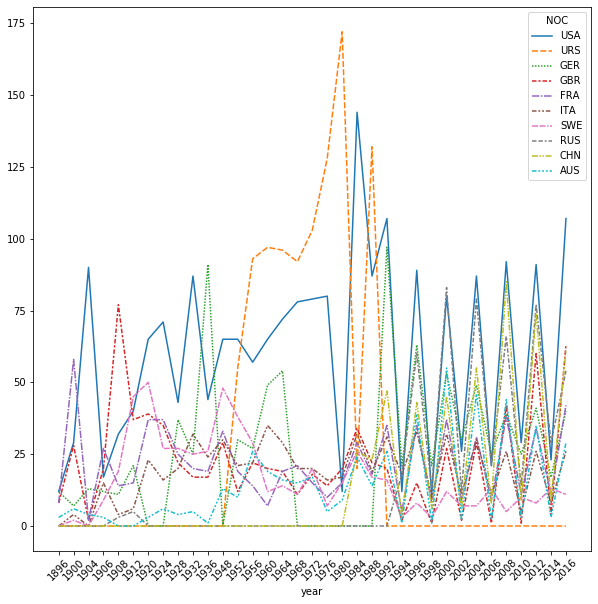

In [66]:
sns.lineplot(data=medals_country_wide_df)
plt.xticks(rotation=45)
plt.show()

Looks like we forgot something, we are plotting the amount of medals per year and not cumulative, fortunately a builtin method can solve this

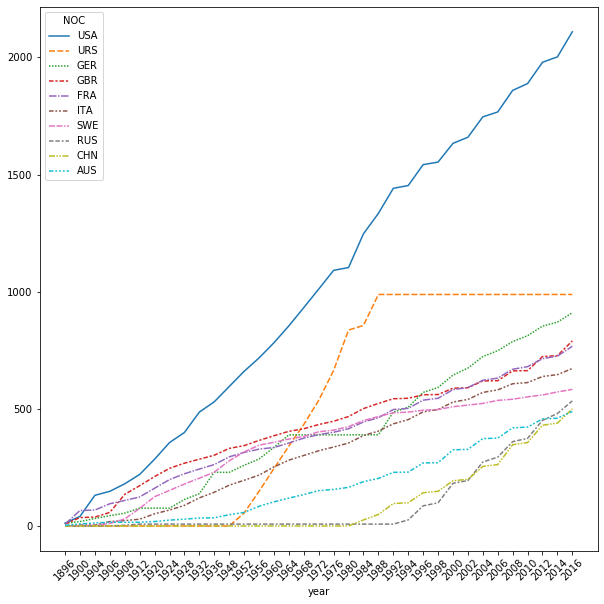

In [67]:
sns.lineplot(data=medals_country_wide_df.cumsum())
plt.xticks(rotation=45)
plt.show()

I did the same for the population corrected data, creating a line plot, this is in my opinion more interesting as it gives a more honest take on the competition.

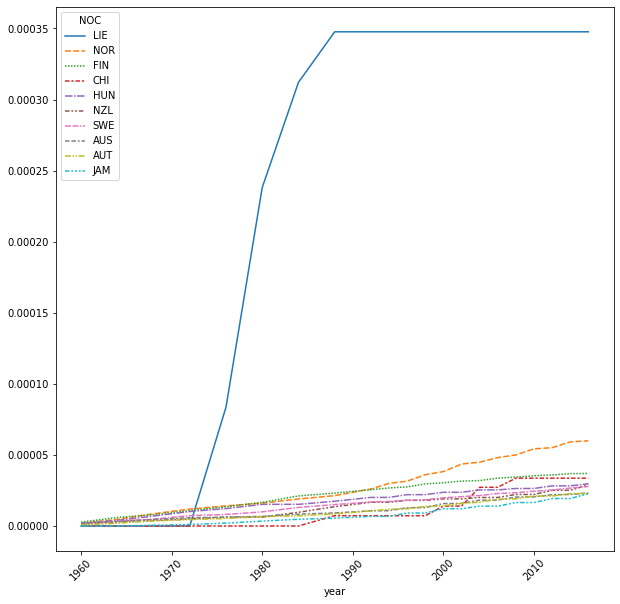

In [68]:
most_medals_pop = medals_pop_df.groupby('NOC')[['Gold','Silver','Bronze']].sum().sum(axis='columns').sort_values(ascending=False).head(10).index.values
medals_pop_df['year'] = medals_pop_df.index.get_level_values('Games').str[:4].astype('int')
medals_country_wide_pop_df = medals_pop_df.reset_index().groupby(['year','NOC'])[['Gold', 'Silver', 'Bronze']].sum().sum(axis='columns').unstack()
medals_country_wide_pop_df = medals_country_wide_pop_df[most_medals_pop].fillna(0)
sns.lineplot(data=medals_country_wide_pop_df.cumsum())
plt.xticks(rotation=45)
plt.show()

There seems to have been a golden age for Liechtenstein, as they are taking up a lot of space I opted to remove them and plot again

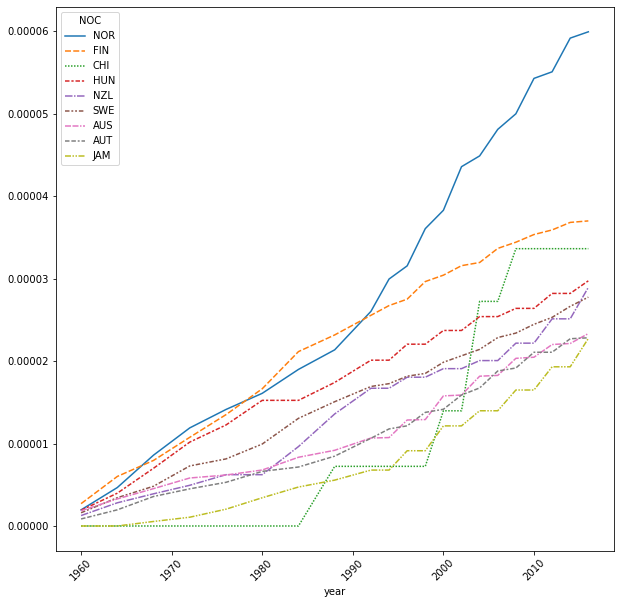

In [69]:
sns.lineplot(data=medals_country_wide_pop_df.drop(columns=['LIE']).cumsum())
plt.xticks(rotation=45)
plt.show()

Great! a lot of other interesting countries performances, note that CHI stands for Chile which catches up phenomenally.

Another take would be a pie chart, although not my favorite it would make a good option in this situation, as we want to compare the relative portions of countries. When we use the regular data we obtain the following.

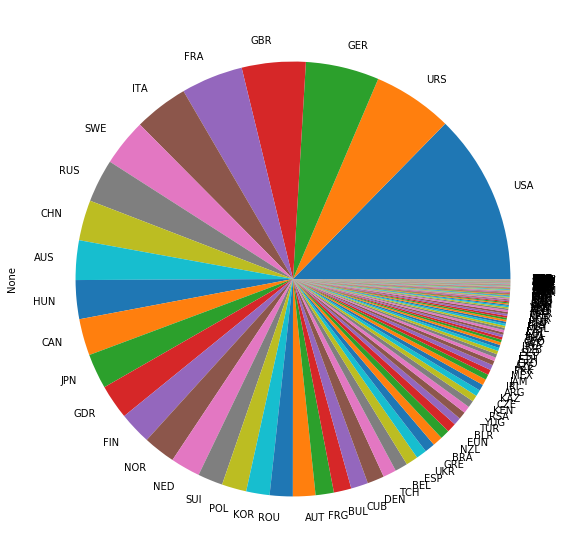

In [70]:
medals_country_df.groupby(level='NOC').sum().sum(axis='columns').sort_values(ascending=False).plot.pie()

Verry messy, as most countries are not visible on the pie chart, a good option would be to only take the top 20 countries and put the others in a 'other' category.

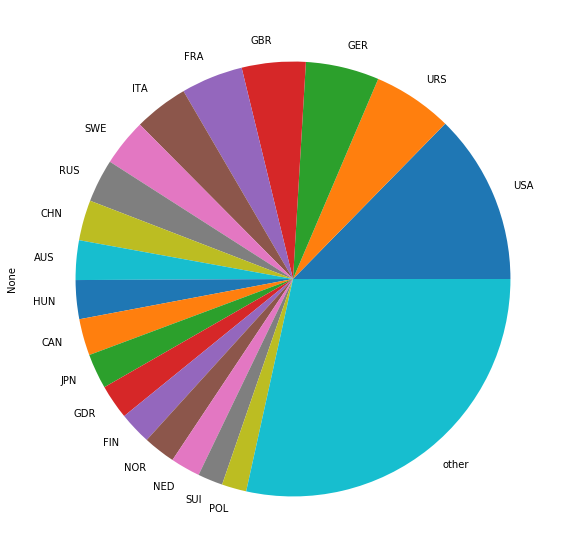

In [71]:
medals_country_vis_df = medals_country_df.groupby(level='NOC').sum().sum(axis='columns').sort_values(ascending=False)[:19]
medals_country_vis_df['other'] = medals_country_df.groupby(level='NOC').sum().sum(axis='columns').sort_values(ascending=False)[19:].sum()
medals_country_vis_df.plot.pie()

Much better, with this pie plot we can see that 10 countries obtained about half of all medals and the next 10 have about 25%, the other 130 countries are in the botton quarter.

Now to add more depth we can divide our dataset, something we mentioned earlier is the dominance in winter sports, here we create the same pie chart but only take events from winter games.

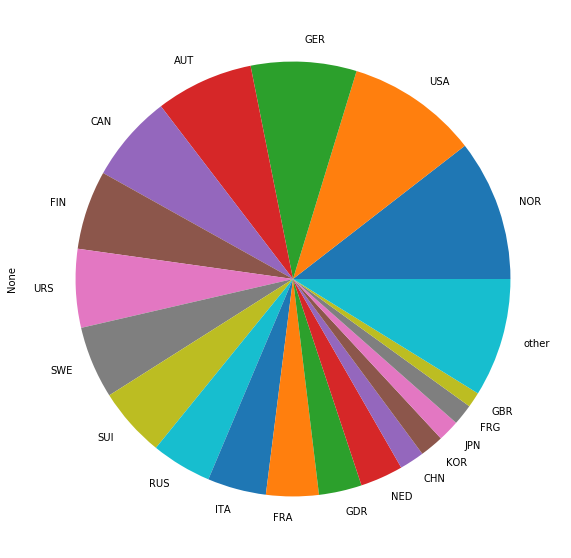

In [72]:
medals_winter_df = medals_country_df[medals_country_df.season=='Winter'].groupby(level='NOC').sum().sum(axis='columns').sort_values(ascending=False)[:19]
medals_winter_df['other'] = medals_country_df[medals_country_df.season=='Winter'].groupby(level='NOC').sum().sum(axis='columns').sort_values(ascending=False)[19:].sum()
medals_winter_df.plot.pie()

You can compare them and see that some countries fall and some rise, indicating that countries definitely have a preference.

Again we can do the same with population corrected data.

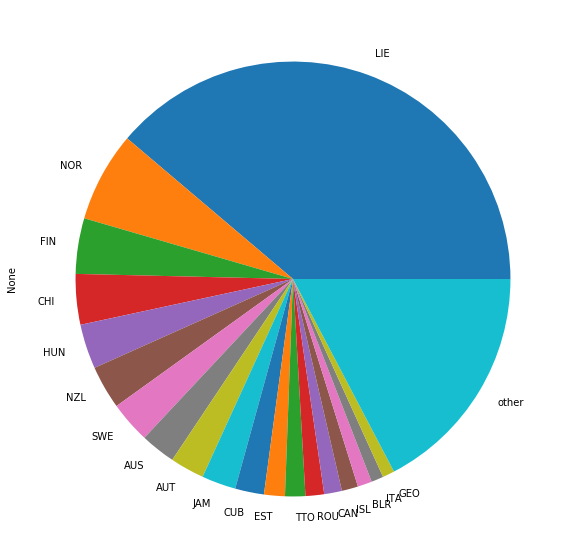

In [73]:
medals_pop_vis_df = medals_pop_df.groupby(level='NOC').sum()[['Gold','Silver','Bronze']].sum(axis='columns').sort_values(ascending=False)[:19]
medals_pop_vis_df['other'] = medals_pop_df.groupby(level='NOC').sum()[['Gold','Silver','Bronze']].sum(axis='columns').sort_values(ascending=False)[19:].sum()
(medals_pop_vis_df*1200).plot.pie()

Or GDP corrected data

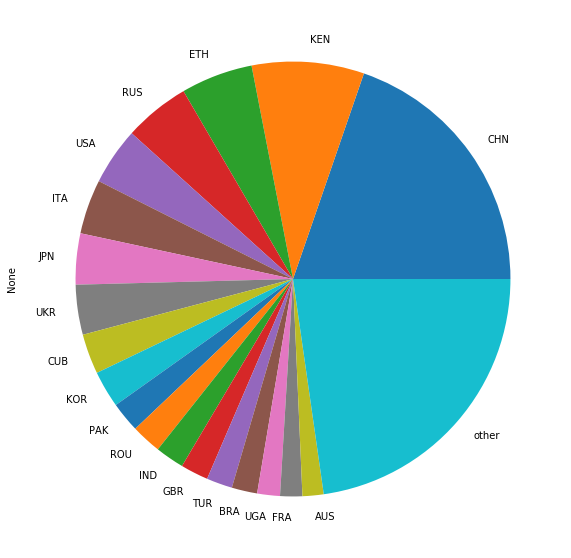

In [74]:
medals_gdp_vis_df = medals_country_gdp_df.groupby(level='NOC').sum()[['Gold','Silver','Bronze']].sum(axis='columns').sort_values(ascending=False)[:19]
medals_gdp_vis_df['other'] = medals_country_gdp_df.groupby(level='NOC').sum()[['Gold','Silver','Bronze']].sum(axis='columns').sort_values(ascending=False)[19:].sum()
medals_gdp_vis_df.plot.pie()

### best performing per sport

To visualise the best performing country per sport we first need the country that won the most medals per sport. we do this with the following code

In [75]:
best_country_sport_df = pd.concat(
    [
        medals_country_df.groupby(level=['NOC', 'Sport']).sum().sum(axis='columns').groupby(level='Sport').apply(lambda x: x.idxmax()[0]),
        medals_country_df.groupby(level=['NOC', 'Sport']).sum().sum(axis='columns').groupby(level='Sport').apply(lambda x: x.max())
    ], axis='columns', keys=['country', 'medals']
)

best_country_sport_df.head()

,country,medals
Sport,,
Aeronautics,SUI,1
Alpine Skiing,AUT,80
Alpinism,AUS,1
Archery,KOR,30
Art Competitions,GER,20


As there are to many sports, I opted to only visualise the top 20 most popular sports, by the amount of medals

In [76]:
total_medals_sport = medals_country_df.groupby(level='Sport').sum().sum(axis='columns').rename('medals').sort_values(ascending=False).reset_index().head(20)
popular_sports = list(total_medals_sport.Sport)
best_country_sport_df.loc[popular_sports].medals

Sport
Athletics               521
Swimming                404
Wrestling               116
Boxing                  100
Gymnastics              118
Rowing                   81
Shooting                 94
Cycling                  84
Canoeing                 80
Weightlifting            55
Fencing                 105
Judo                     84
Sailing                  58
Speed Skating            71
Equestrianism            59
Cross Country Skiing     83
Alpine Skiing            80
Diving                   73
Figure Skating           41
Biathlon                 38
Name: medals, dtype: int64

Now we can create a bar plot, where the portion of each best performing country is shown together with the region name.

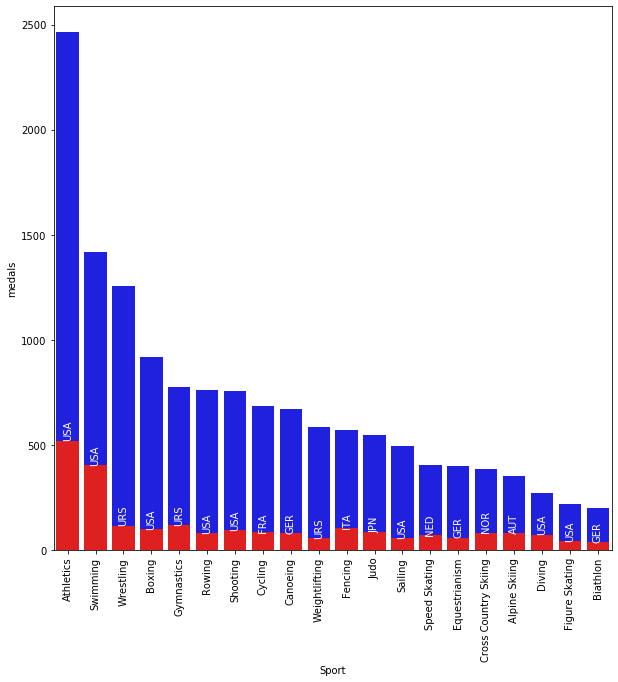

In [77]:
sns.barplot(x=total_medals_sport.Sport.astype('str'), y=total_medals_sport.medals, color='b')
sns.barplot(x=popular_sports, y=best_country_sport_df.loc[popular_sports].medals, color='r')

for idx, sport in enumerate(popular_sports):
    plt.text(idx, best_country_sport_df.loc[sport].medals+10, best_country_sport_df.loc[sport].country, horizontalalignment='center', size='medium', color='white', rotation=90)

plt.xticks(rotation=90)
plt.show()

This both indicates the popularity of the sport (by amount of total medals) and the amount of medals won by the best performing country.

Another approach would be to use the difference between truth and expected values, we calculated the difference earlier.

In [78]:
medals_sport_diff_df.head()

Sport,Aeronautics,Alpine Skiing,Alpinism,Archery,Art Competitions,Athletics,Badminton,Baseball,Basketball,Basque Pelota,...,Table Tennis,Taekwondo,Tennis,Trampolining,Triathlon,Tug-Of-War,Volleyball,Water Polo,Weightlifting,Wrestling
NOC,,,,,,,,,,,,,,,,,,,,,
AFG,-0.000120,-0.042382,-0.000720,-0.017649,-0.016088,-0.295714,-0.009845,-0.001801,-0.010806,-0.000120,...,-0.009125,1.982711,-0.022212,-0.003122,-0.003002,-0.001801,-0.010085,-0.011406,-0.070477,-0.151039
AHO,-0.000060,-0.021191,-0.000360,-0.008825,-0.008044,-0.147857,-0.004923,-0.000900,-0.005403,-0.000060,...,-0.004562,-0.008644,-0.011106,-0.001561,-0.001501,-0.000900,-0.005043,-0.005703,-0.035238,-0.075519
ALG,-0.001021,-0.360247,-0.006123,-0.150018,-0.136751,6.486433,-0.083684,-0.015308,-0.091848,-0.001021,...,-0.077560,-0.146956,-0.188798,-0.026534,-0.025513,-0.015308,-0.085725,-0.096950,-0.599052,-1.283828
ANZ,-0.000660,-0.233101,-0.003962,-0.097070,-0.088486,-0.626426,-0.054148,-0.009905,-0.059431,-0.000660,...,-0.050186,-0.095089,0.877836,-0.017169,-0.016509,-0.009905,-0.055469,-0.062733,-0.387622,-0.830712
ARG,-0.004442,-1.568135,-0.026654,-0.653020,-0.595270,-5.941410,-0.364269,-0.066635,1.600192,-0.004442,...,-0.337616,0.360307,4.178173,-0.115500,-0.111058,-0.066635,0.626846,-0.422019,-0.607636,-5.588426


By sorting on the values in this matrix, we find the combination of region and sport that are most extreme, meaning either much more medals then expected, or much less medals than expected.

In [79]:
medals_diff_df = medals_sport_diff_df.stack().sort_values(ascending=False)
medals_diff_df.head()

NOC  Sport    
USA  Swimming     224.472926
     Athletics    209.169828
AUS  Swimming     132.374235
ITA  Fencing       82.005643
GBR  Athletics     78.193060
dtype: float64

So now we know that USA has aboutn 224 more medals in Swimming than expected, we could put this in a bar chart

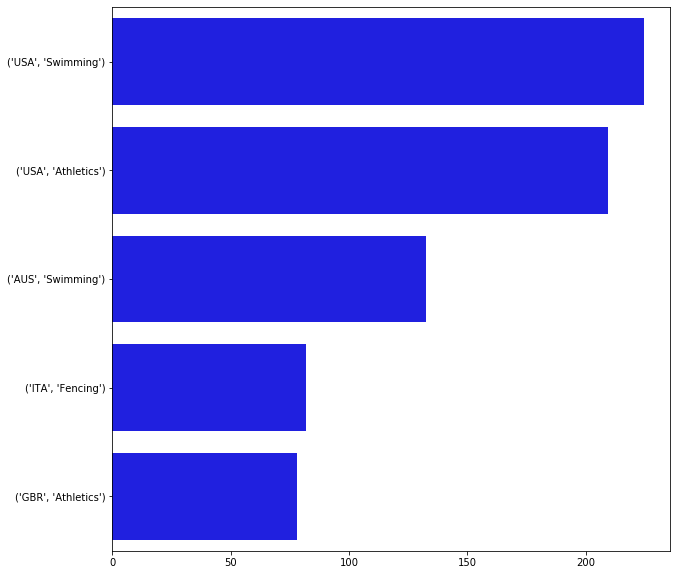

In [80]:
sns.barplot(x=medals_diff_df.head(), y=medals_diff_df.head().index.values, color='b')
plt.show()

This reveals that USA seems to be investing a lot in Swimming or Athletics sports, which are by coincidence sports that have the most medals.
You could argue that due to the cold war show-off they have fallen prey to the cobra effect where they used the amount of medals they could get as a target instead of a measure of performance, shifting them towards sports where more medals can be obtained.

Anyway, the same analysis can be done for the worst combinations.

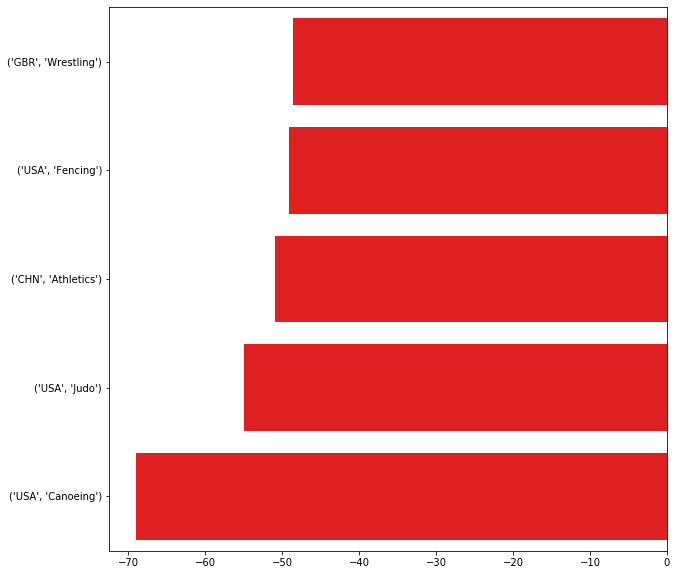

In [81]:
sns.barplot(x=medals_diff_df.tail(), y=medals_diff_df.tail().index.values, color='r')
plt.show()

This analysis can also be performed on Country level, here we see that Belgium is good at

In [82]:
medals_sport_diff_df.loc['BEL']

Sport
Aeronautics         -0.009425
Alpine Skiing       -3.326990
Alpinism            -0.056549
Archery             14.614540
Art Competitions     4.737063
                      ...    
Tug-Of-War           0.858626
Volleyball          -0.791692
Water Polo           5.104634
Weightlifting       -2.532417
Wrestling           -7.856525
Name: BEL, Length: 66, dtype: float64

And we can put this in the same type of barchart to make it comparible with the previous chart

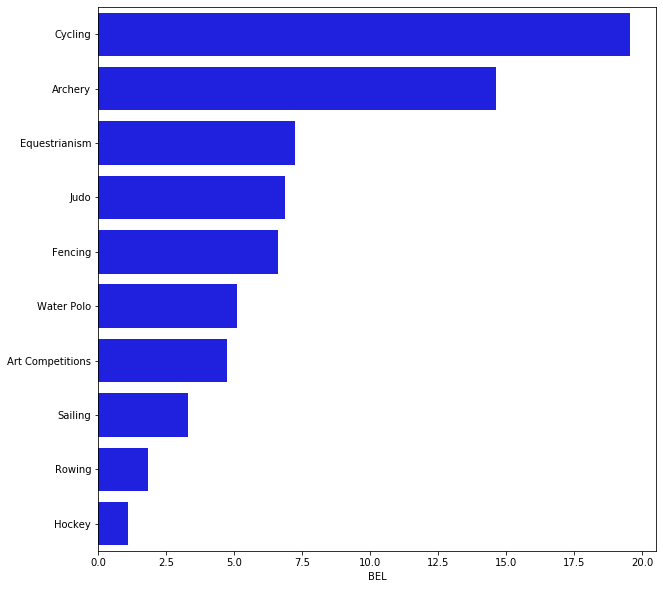

In [83]:
sns.barplot(x=medals_sport_diff_df.loc['BEL'].sort_values(ascending=False).head(10), y=medals_sport_diff_df.loc['BEL'].sort_values(ascending=False).head(10).index.astype('str').values, color='b')



### Athlete attributes

We also investigated athlete specific attributes, to refresh our memory a printout of how the dataset looks

In [84]:
df = athlete_events.drop_duplicates(subset=['Name', 'Age', 'NOC'])
df = df.dropna(subset=['Age', 'Height', 'Weight'])[['Sex', 'Sport', 'Medal', 'Age', 'Height', 'Weight']].reset_index(drop=True)
df.head()

,Sex,Sport,Medal,Age,Height,Weight
0,M,Basketball,NaN,24.0,180.0,80.0
1,M,Judo,NaN,23.0,170.0,60.0
2,F,Speed Skating,NaN,21.0,185.0,82.0
3,F,Speed Skating,NaN,25.0,185.0,82.0
4,F,Speed Skating,NaN,27.0,185.0,82.0


I kept features such as gender, Sport, ... as these were attributes on which the physical appearance was different, we can use these features to group our athletes and visualise the distribution with a histogram.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


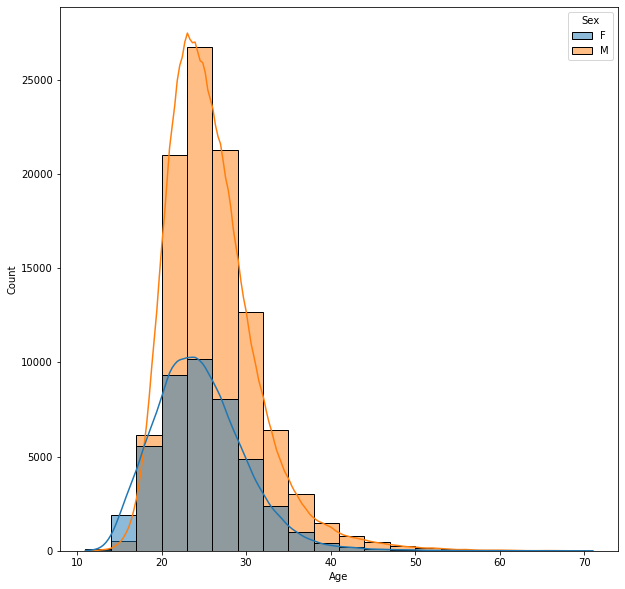

In [85]:
sns.histplot(data = df, x='Age', hue='Sex', bins=20, kde=True)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


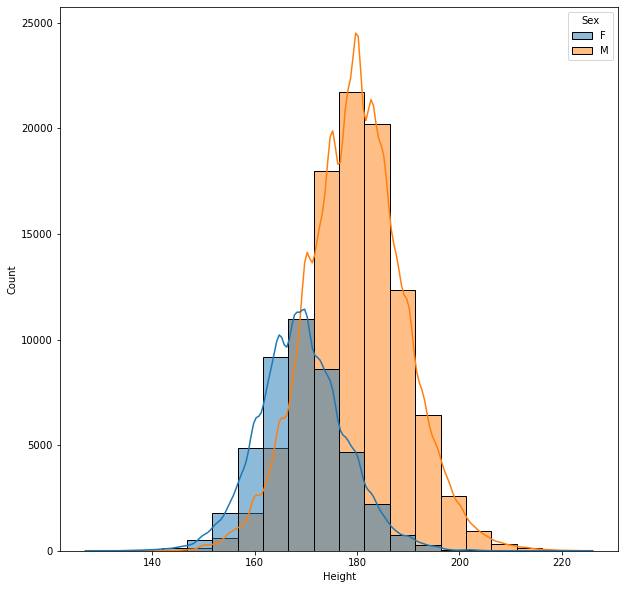

In [86]:
sns.histplot(data = df, x='Height', hue='Sex', bins=20, kde=True)

For gender, the difference in age is not that appearent, yet the shift in height is, women are in general less tall as men.

When grouping per sport we saw significant differences.

/home/lorenzf/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

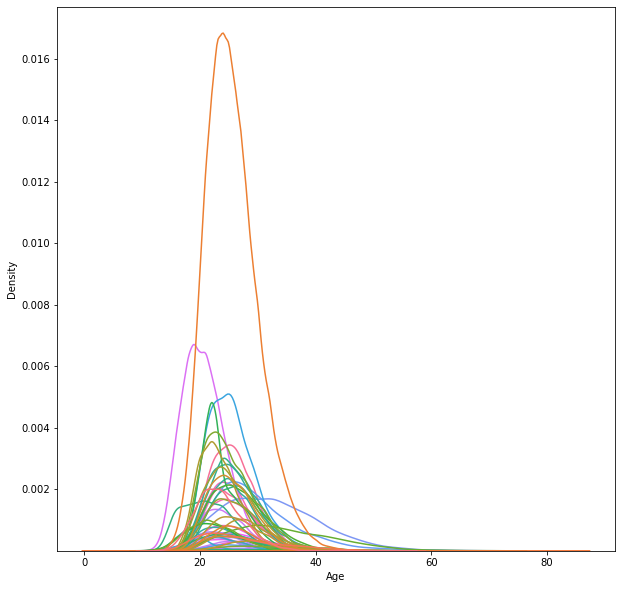

In [87]:
ax = sns.kdeplot(data=df, x='Age', hue='Sport')
plt.legend().remove()

If we put all sports like this in a distribution plot, it becomes a big mess, I had to remove the legend as there are a lot of sports and the bins all overlap. It seems not a good idea to make such a plot.

For medals we only have 3 different groups.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


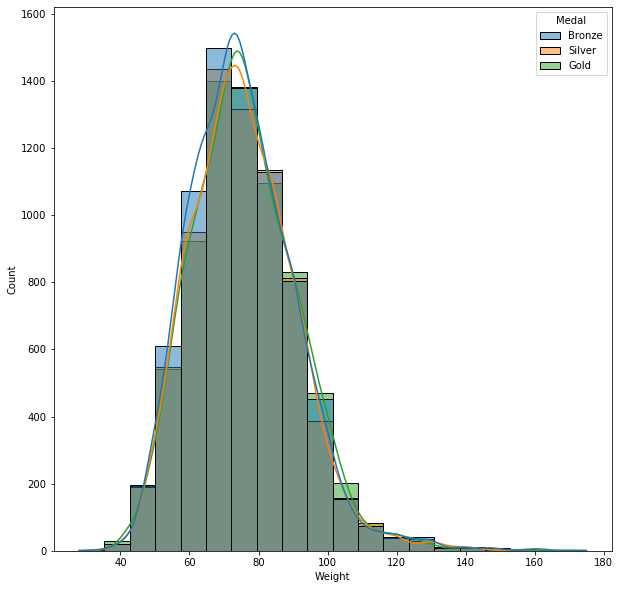

In [88]:
ax = sns.histplot(data=df, x='Weight', hue='Medal', bins=20, kde=True)

Obviously for each ceremony we have 1 gold, 1 silver and 1 bronze, so distributions are equal in size.
We saw erlier that the groups do not have significant differences and this is confirmed with the histogram, although you can see some small differences that perhaps show a pattern?

Lastly I would like to add another dimension to the plots by using scatterplots, it will be messy but creates a new perspective.
For the scatter plot I would first plot all athlete's height and weight (you could add lines of equal BMI here) and superpose in other colors subgroups of athletes based on groups.
Here I use the sport to show all athletes, gymnastics and weightlifting.

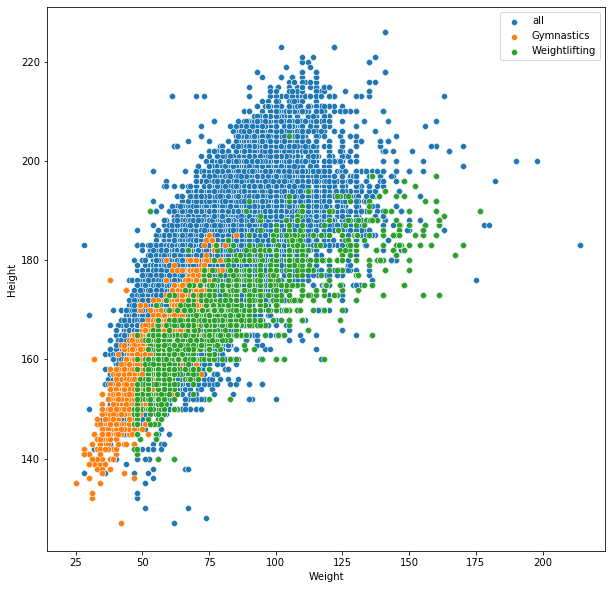

In [89]:
sns.scatterplot(data=df, x='Weight', y='Height', label='all')
sns.scatterplot(data=df[df.Sport=='Gymnastics'], x='Weight', y='Height', label='Gymnastics')
sns.scatterplot(data=df[df.Sport=='Weightlifting'], x='Weight', y='Height', label='Weightlifting')

you can clearly see how gymnastics are the smallest athletes and whilst weightlifting are also fairly small, they have a much higher weight, as they need muscles to perform their sport.

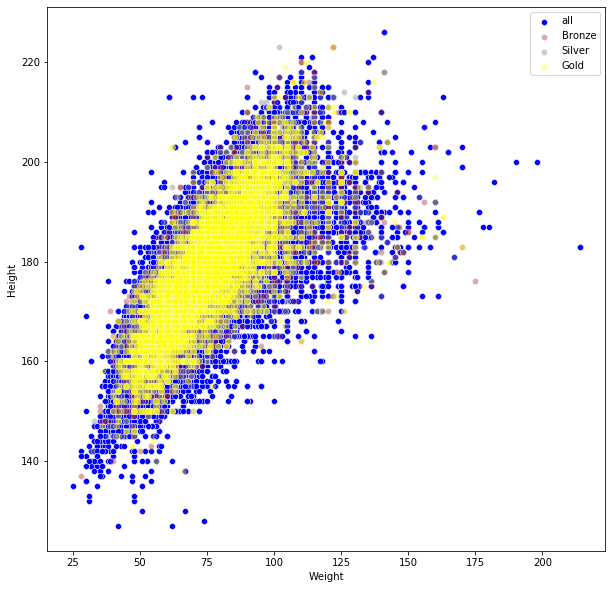

In [90]:
sns.scatterplot(data=df[df.Medal.isna()], x='Weight', y='Height', label='all', color='blue')
sns.scatterplot(data=df[df.Medal=='Bronze'], x='Weight', y='Height', label='Bronze', color='brown', alpha=0.4)
sns.scatterplot(data=df[df.Medal=='Silver'], x='Weight', y='Height', label='Silver', color='grey', alpha=0.4)
sns.scatterplot(data=df[df.Medal=='Gold'], x='Weight', y='Height', label='Gold', color='yellow', alpha=0.4)

Looking at this graph we can see that while there is no difference for athlete that achieves different types of medals, there is a clear area in which you should be in order to be a medal winner, outside that area clearly dimishishes your chances.

Also there seems to be an athlete that is more than 200kgs?

In [91]:
athlete_events[athlete_events.Weight==athlete_events.Weight.max()]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
12177,"Ricardo Blas, Jr.",M,21.0,183.0,214.0,Guam,GUM,2008 Summer,2008,Summer,Beijing,Judo,Judo Men's Heavyweight,NaN
12177,"Ricardo Blas, Jr.",M,25.0,183.0,214.0,Guam,GUM,2012 Summer,2012,Summer,London,Judo,Judo Men's Heavyweight,NaN


## Summary



- Best performing depends on metric
- Some countries focus on different sports due to multiple reasons (# medals, heritage, ...)
- Your sport and physical attributes are related, there is a ideal weight and height